In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from tqdm.auto import tqdm

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

from networks import PerceptNetSeq

print(tf.__version__)

2.6.0


In [2]:
img_height, img_width, channels = 384, 512, 3
input_shape = (img_height, img_width, channels)
# Build the model and load the weights
model = PerceptNetSeq()
model.build(input_shape=(None, 384, 512, 3))
model.load_weights('../saved_networks/model-best.h5')

2022-04-12 15:17:51.314331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:84:00.0, compute capability: 3.5


In [3]:
model.model.layers

In [3]:
inputs = tf.keras.Input((384, 512, 3))
output = inputs
for layer in model.model.layers:
    output = layer(output)
model = tf.keras.Model(inputs, output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 512, 3)]     0         
_________________________________________________________________
gdn (GDN)                    (None, 384, 512, 3)       8         
_________________________________________________________________
conv2d (Conv2D)              (None, 384, 512, 3)       12        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 192, 256, 3)       0         
_________________________________________________________________
gdn_1 (GDN)                  (None, 192, 256, 3)       14        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 256, 6)       456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 128, 6)        0     

In [4]:
# Get the "summary" of the model: order
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 gdn
2 conv2d
3 max_pooling2d
4 gdn_1
5 conv2d_1
6 max_pooling2d_1
7 gdn_2
8 conv2d_2
9 gdn_3


In [5]:
# Model until the output of the first convolution
# model_output_first_conv = tf.keras.Sequential(model.layers[:3])
model_output_first_conv = model
model_output_first_conv.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 512, 3)]     0         
_________________________________________________________________
gdn (GDN)                    (None, 384, 512, 3)       8         
_________________________________________________________________
conv2d (Conv2D)              (None, 384, 512, 3)       12        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 192, 256, 3)       0         
_________________________________________________________________
gdn_1 (GDN)                  (None, 192, 256, 3)       14        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 256, 6)       456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 128, 6)        0     

In [7]:
# Receptive fields:
#       - As a row of the jacobian (1)
#       - Using deltas as input (2)
#       - From the weights (3)
# Let's do all for the filter number 12 and for the center neuron: 24, 64

# First, (1)
@tf.function
def get_jacobian(img, filter_index):
    with tf.GradientTape() as tape:
        tape.watch(img)
        activation = model_output_first_conv(img, training = False)[:,:,:,filter_index]
    jacobian = tape.jacobian(activation, img)
    return jacobian

def initialize_image():
    img_0_to_1 = tf.random.uniform((1, img_height, img_width, channels))
    img_gray = tf.ones((1, img_height, img_width, channels))*0.5
    return img_gray

In [ ]:
# Get the jacobian
jacobian = get_jacobian(initialize_image(), 0)

In [9]:
# See the shape
print(jacobian.shape)
jacobian = jacobian.numpy().squeeze()
print(jacobian.shape)

(1, 48, 128, 1, 48, 128, 3)
(48, 128, 48, 128, 3)


In [10]:
jacobian = jacobian.reshape(img_height*img_width, -1, order = 'C')
print(jacobian.shape)

(6144, 18432)


In [11]:
print(jacobian.min(), jacobian.max())

-0.18138261 0.12485714


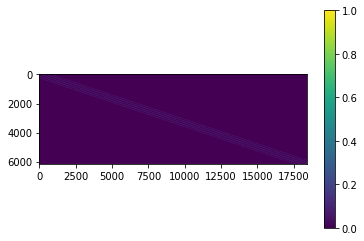

In [12]:
plt.imshow((np.abs(jacobian)/np.abs(jacobian).max())**0.1, vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

In [13]:
neuron = 23*128 + 63

# The receptive field of the neuron is the row of the jacobian
receptive_field = jacobian[neuron,:]
print(receptive_field.shape)

(18432,)


0.0 1.0
(48, 128, 3)


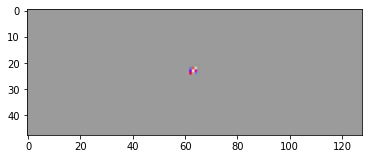

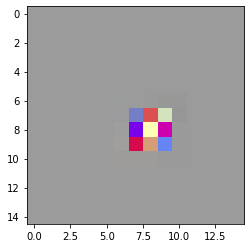

In [14]:
# Normalize, reshape and plot
receptive_field = (receptive_field - receptive_field.min()) / (receptive_field.max() - receptive_field.min())
print(receptive_field.min(), receptive_field.max())
receptive_field = receptive_field.reshape((img_height, img_width, channels), order = 'C')
print(receptive_field.shape)

plt.imshow(receptive_field, vmin = 0, vmax = 1)
plt.show()

# Zoom
plt.imshow(receptive_field[15:30,55:70], vmin = 0, vmax = 1)
plt.show()

### Using deltas

The idea is to generate images consisting of deltas in one pixel so that the image is a matrix full of 0s with a single 1. This idea is simple, but the corresponding array of deltas is too big and thus, we have to create them on the fly, because we can't store the full array of deltas in memory.

> Using sparse tensors might be useful for our case: https://www.tensorflow.org/guide/sparse_tensor?hl=en

In [18]:
def obtain_receptive_field(model, img_height, img_width, channels, fov=32, channel_to_keep=0):
    """
    This function calculates the receptive field of a model by building a set of deltas and
    calculating the response of the model for each delta. As of now, the calculations are
    made only for the center neuron using a predetermined FOV: only a range [-FOV, FOV] centered
    on the center neuron is used.

    Parameters
    ----------
    model: 
        Model we want to calculate the receptive field from.
    img_height:
        Height of the images that the model accepts.
    img_width:
        Width of the images that the model accepts.
    channels:
        Number of channels of the images that the model accepts.
    fov:
        Field Of View as explained before.
    channel_to_keep:
        Channel to keep when keeping the response.
    
    Returns
    -------
    receptive_field:
        Array containing the receptive field.
    """
    ## Define deltas and obtain their responses
    responses = []
    for i in tqdm(range(img_height//2-fov, img_height//2+fov), desc='outer'):
        for j in range(img_width//2-fov, img_width//2+fov):
            for k in range(channels):
                zero = np.zeros((img_height, img_width, channels))
                zero[i,j,k] = 1
                response = model.predict(zero[None,:,:,:])
                ## Now we keep only the center response of a specific channel
                response_height, response_width = response.shape[1:3] # [BatchDim, H, W, C]
                responses.append(response[0,response_height//2,response_width//2,channel_to_keep])
    
    ## Turn the list into an array
    receptive_field = np.array(responses)
    ## Reshape so it has image-like shape and is plotable
    receptive_field = receptive_field.reshape((fov*2, fov*2, channels))

    return receptive_field

In [37]:
def obtain_receptive_field_gen(img_height, img_width, channels, fov=32):
    """
    This generator yields the deltas needed to calculate the receptive
    field of a model.

    Parameters
    ----------
    img_height:
        Height of the images that the model accepts.
    img_width:
        Width of the images that the model accepts.
    channels:
        Number of channels of the images that the model accepts.
    fov:
        Field Of View as explained before.
    
    Returns
    -------
    receptive_field:
        Array containing the receptive field.
    """
    ## Define deltas
    for i in range(img_height//2-fov, img_height//2+fov):
        for j in range(img_width//2-fov, img_width//2+fov):
            for k in range(channels):
                zero = np.zeros((img_height, img_width, channels))
                zero[i,j,k] = 1

                yield zero

In [42]:
deltas_dataset = tf.data.Dataset.from_generator(obtain_receptive_field_gen, 
                                                args=(img_height,img_width,channels,32),
                                                output_signature=(
                                                    tf.TensorSpec(shape=(img_height,img_width,channels), dtype=tf.float32)
                                                    )
                                                )

In [56]:
%%time
fov = 32
channel_to_keep = 0
batch_size = 4

responses = np.empty(shape=(fov*2)*(fov*2)*channels)
for i, delta in tqdm(enumerate(deltas_dataset.batch(batch_size))):
    response = model.predict(delta)
    ## Now we keep only the center response of a specific channel
    response_height, response_width = response.shape[1:3] # [BatchDim, H, W, C]
    # responses.append(response[0,response_height//2,response_width//2,channel_to_keep])
    responses[i*batch_size:i*batch_size+batch_size] = response[:,response_height//2,response_width//2,channel_to_keep]

0it [00:00, ?it/s]

CPU times: user 5min 20s, sys: 51 s, total: 6min 11s
Wall time: 5min 31s


In [ ]:
responses2 = responses.reshape((fov*2, fov*2, channels))
rf = (responses2 - responses2.min()) / (responses2.max() - responses2.min())
rf.shape

(64, 64, 3)

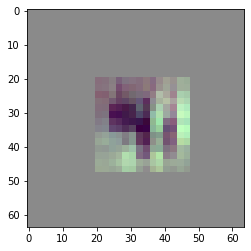

In [ ]:
plt.imshow(rf)
plt.show()

In [14]:
%%time
fov = 32
channel_to_keep = 0

responses = np.empty(shape=(fov*2)*(fov*2)*channels)
l = 0
for i in tqdm(range(img_height//2-fov, img_height//2+fov), desc='outer'):
    for j in range(img_width//2-fov, img_width//2+fov):
        for k in range(channels):
            zero = np.zeros((img_height, img_width, channels))
            zero[i,j,k] = 1
            response = model.predict(zero[None,:,:,:])
            ## Now we keep only the center response of a specific channel
            response_height, response_width = response.shape[1:3] # [BatchDim, H, W, C]
            # responses.append(response[0,response_height//2,response_width//2,channel_to_keep])
            responses[l] = response[0,response_height//2,response_width//2,channel_to_keep]
            l += 1
    #         break
    #     break
    # break

## Turn the list into an array
receptive_field = np.array(responses)
## Reshape so it has image-like shape and is plotable
receptive_field = receptive_field.reshape((fov*2, fov*2, channels))

outer:   0%|          | 0/64 [00:00<?, ?it/s]

CPU times: user 15min 16s, sys: 2min 22s, total: 17min 38s
Wall time: 15min 4s


In [ ]:
rf = (receptive_field - receptive_field.min()) / (receptive_field.max() - receptive_field.min())
rf.shape

(64, 64, 3)

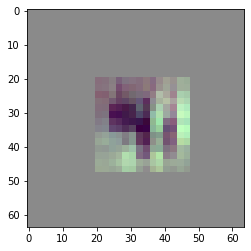

In [ ]:
plt.imshow(rf)
plt.show()

In [19]:
rf_func = obtain_receptive_field(model_output_first_conv,
                                 img_height=img_height,
                                 img_width=img_width,
                                 channels=channels,
                                 fov=32,
                                 channel_to_keep=0)
rf_func.shape

outer:   0%|          | 0/64 [00:00<?, ?it/s]

(64, 64, 3)

In [20]:
rf = (rf_func - rf_func.min()) / (rf_func.max() - rf_func.min())
rf.shape

(64, 64, 3)

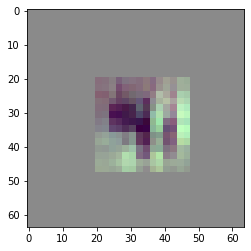

In [21]:
plt.imshow(rf)
plt.show()

In [22]:
plt.imshow(rf[fov-6:fov+6, fov-6:fov+6,:])
plt.show()

NameError: name 'fov' is not defined

In [ ]:
rf_func = obtain_receptive_field(model_output_first_conv,
                                 img_height=img_height,
                                 img_width=img_width,
                                 channels=channels,
                                 fov=32,
                                 channel_to_keep=0)
rf_func.shape

outer:   0%|          | 0/64 [00:00<?, ?it/s]

In [42]:
# receptive_field_loop = []
# for i in range(len(deltas)):
#     receptive_field_loop.append(responses[i][0,23,63])

# print(len(receptive_field_loop))

# # Reshape
# receptive_field_loop = np.array(receptive_field_loop).reshape((img_height, img_width, channels), order = 'C')
# print(receptive_field_loop.shape)

# receptive_field_loop = (receptive_field_loop - receptive_field_loop.min()) / (receptive_field_loop.max() - receptive_field_loop.min())

# #Plot
# plt.imshow(receptive_field_loop, vmin = 0, vmax = 1)
# plt.show()

# # Zoom
# plt.imshow(receptive_field_loop[15:30,55:70], vmin = 0, vmax = 1)
# plt.show()

In [17]:
# Thrid, (3)
filters, biases = [layer.get_weights() for layer in model.layers if layer.name == 'conv2d'][0]
filter_12 = filters[:,:,:,12]

In [18]:
filter_12 = (filter_12 - filter_12.min()) / (filter_12.max() - filter_12.min())

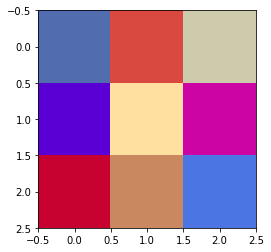

In [19]:
plt.imshow(filter_12)
plt.show()

(6144, 18432)


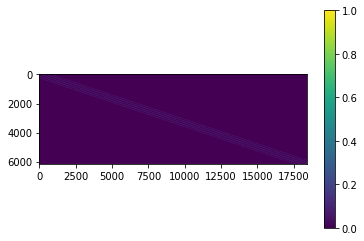

In [21]:
# Stimulus that maximizes the response of a neuron:
#       - As a colum of the inverse of the jacobian (1)
#       - From a iterative process using the gradient (2)
# Let's do all for the filter number 12 and for the center neuron: 24, 64

# First, (1): From the jacobian, the pseudo-inverse
print(jacobian.shape)

plt.imshow((np.abs(jacobian)/np.abs(jacobian).max())**0.1, vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

(18432, 6144)


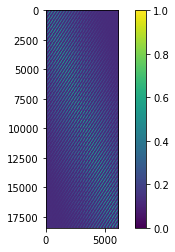

In [22]:
# We have to use the pseudo-inverse as it is not a square matrix
inverse_jacobian = np.linalg.pinv(jacobian, rcond = 1e-6)
print(inverse_jacobian.shape)

# PLot the pseudo-inverse
plt.imshow((np.abs(inverse_jacobian)/np.abs(inverse_jacobian).max())**0.1, vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

# Select the column and reshape
max_stimulus = inverse_jacobian[:,neuron]
max_stimulus = max_stimulus.reshape((img_height, img_width, channels), order = 'C')

(48, 128, 3) -1.0010569 0.86278534


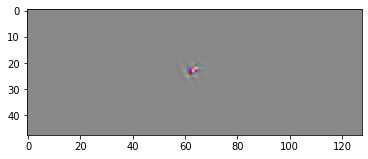

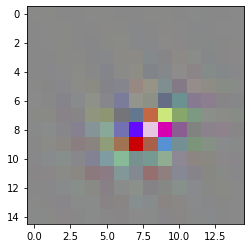

In [23]:
print(max_stimulus.shape, max_stimulus.min(), max_stimulus.max())

max_stimulus = (max_stimulus - max_stimulus.min()) / (max_stimulus.max() - max_stimulus.min())

plt.imshow(max_stimulus, vmin = 0, vmax = 1)
plt.show()

# Zoom
plt.imshow(max_stimulus[15:30,55:70], vmin = 0, vmax = 1)
plt.show()

In [6]:
# Now, (2)
def compute_loss(input_image, filter_index):
    activation = model_output_first_conv(input_image, training = False)
    filter_activation = activation[:, 23, 63, filter_index] # Activation of the studied neuron
    surrounding_activation = activation[:,:,:,filter_index] # Activation of all the neurons of the filter
    surrounding_activation = tf.tensor_scatter_nd_update(surrounding_activation, [[0,23,63]], [0]) # Set 0 the activation of the neuron to get only the activations of the surrounding neurons
    studied_neuron = tf.reduce_mean(tf.math.abs(filter_activation))
    surrounding_neurons = tf.reduce_mean(tf.math.abs(surrounding_activation))
    loss =  studied_neuron - surrounding_neurons # Maximize the activation of the studied neuron and minimize the others
    return loss, studied_neuron, surrounding_neurons

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss, filter_loss, surrounding_loss = compute_loss(img, filter_index)
    grads = tape.gradient(loss, img)
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, filter_loss, surrounding_loss, img

def initialize_image():
    img_0_to_1 = tf.random.uniform((1, img_height, img_width, channels))
    img_gray = tf.ones((1, img_height, img_width, channels))*0.5
    return img_gray

def iterative_process(filter_index):
    iterations = 3000
    learning_rate = 5.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, filter_loss, neighborhood_loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    return loss, img.numpy()

In [7]:
loss, max_stimulus_iterative = iterative_process(filter_index=0)

2022-04-11 17:28:39.135504: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-11 17:28:39.842875: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-04-11 17:28:40.305553: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(1, 384, 512, 3) -91.367134 51.964096
0.0 1.0


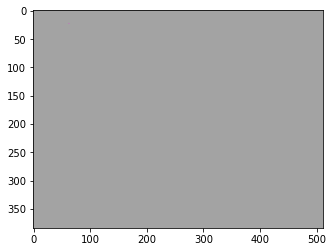

In [8]:
print(max_stimulus_iterative.shape, max_stimulus_iterative.min(), max_stimulus_iterative.max())

#Normalize
max_stimulus_iterative = (max_stimulus_iterative - max_stimulus_iterative.min()) / (max_stimulus_iterative.max() - max_stimulus_iterative.min())
print(max_stimulus_iterative.min(), max_stimulus_iterative.max())

# Plot
plt.imshow(max_stimulus_iterative[0], vmin = 0, vmax = 1)
plt.show()

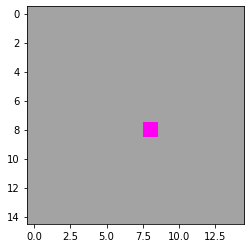

In [9]:
# Zoom
plt.imshow(max_stimulus_iterative[0, 15:30,55:70, :], vmin = 0, vmax = 1)
plt.show()

(48, 128, 3) 0.0 1.0
(1, 48, 128, 3) 0.0 1.0


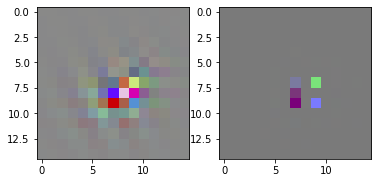

In [41]:
# They look so different, so check them lets pass these stimulus to the model and get the reponses: they are suposed to maximize the response of the central neuron and minimize the others
print(max_stimulus.shape, max_stimulus.min(), max_stimulus.max())
print(max_stimulus_iterative.shape, max_stimulus_iterative.min(), max_stimulus_iterative.max())

plt.subplot(1,2,1)
plt.imshow(max_stimulus[15:30,55:70,:], vmin = 0, vmax = 1)
plt.subplot(1,2,2)
plt.imshow(max_stimulus_iterative[0,15:30,55:70,:], vmin = 0, vmax = 1)
plt.show()


In [43]:
response_max_stimulus = model_output_first_conv(max_stimulus[None,:,:,:]).numpy()[0,:,:,12]
response_max_stimulus_iterative = model_output_first_conv(max_stimulus_iterative).numpy()[0,:,:,12]

print(response_max_stimulus.shape, response_max_stimulus.min(), response_max_stimulus.max())
print(response_max_stimulus_iterative.shape, response_max_stimulus_iterative.min(), response_max_stimulus_iterative.max())

response_max_stimulus = (response_max_stimulus - response_max_stimulus.min()) / (response_max_stimulus.max() - response_max_stimulus.min())
response_max_stimulus_iterative = (response_max_stimulus_iterative - response_max_stimulus_iterative.min()) / (response_max_stimulus_iterative.max() - response_max_stimulus_iterative.min())

print(response_max_stimulus.min(), response_max_stimulus.max(), response_max_stimulus_iterative.min(), response_max_stimulus_iterative.max())

(48, 128) -0.050822727 0.52578336
(48, 128) -0.047835164 0.19862746
0.0 1.0 0.0 1.0


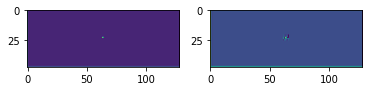

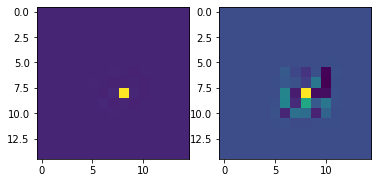

In [47]:
plt.subplot(1,2,1)
plt.imshow(response_max_stimulus, vmin = 0, vmax = 1)
plt.subplot(1,2,2)
plt.imshow(response_max_stimulus_iterative, vmin = 0, vmax = 1)
plt.show()

plt.subplot(1,2,1)
plt.imshow(response_max_stimulus[15:30,55:70], vmin = 0, vmax = 1)
plt.subplot(1,2,2)
plt.imshow(response_max_stimulus_iterative[15:30,55:70], vmin = 0, vmax = 1)
plt.show()